# Review generation as Neural Machine Translation task

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

import re
import os
import time

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
# https://www.tensorflow.org/tutorials/text/nmt_with_attention
def preprocess_sentence(w):
    w = w.lower().strip()

    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

    w = w.strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    return w

In [4]:
def load_dataset(num_reviews):
    ds = tfds.load('amazon_us_reviews/Video_Games_v1_00', data_dir='/hdd/tf_datasets', 
                   split='train', shuffle_files=True).take(num_reviews)
    fields = [[i['data']['product_title'].decode("utf-8"), 
               i['data']['review_body'].decode("utf-8"), 
               i['data']['review_headline'].decode("utf-8")] for i in ds.as_numpy_iterator()
               if len(i['data']['review_body'].decode("utf-8").split('.')) > 4 and \
                  len(i['data']['review_body'].decode("utf-8")) > 20]
    
    x = [i[0] + ' reviewtitle ' + i[2] + ' reviewcontent ' + '. '.join(i[1].split('.')[::3]) for i in fields]
    y = [i[1] for i in fields]

    x = [preprocess_sentence(i) for i in x]
    y = [preprocess_sentence(i) for i in y]

    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=3000, filters='', oov_token='<unk>')
    tokenizer.fit_on_texts(x + y)
    
    x = tokenizer.texts_to_sequences(x)
    y = tokenizer.texts_to_sequences(y)

    x = tf.keras.preprocessing.sequence.pad_sequences(x, padding='post', maxlen=100)
    y = tf.keras.preprocessing.sequence.pad_sequences(y, padding='post', maxlen=100)
    
    return x, y, tokenizer

In [5]:
x, y, tokenizer = load_dataset(10)

In [6]:
def tokens_to_words(tokenizer, tensor):
    for t in tensor:
        if t != 0:
            print ("%d ----> %s" % (t, tokenizer.index_word[t]))

tokens_to_words(tokenizer, x[1])

21 ----> <start>
113 ----> theresia
73 ----> nintendo
35 ----> ds
46 ----> reviewtitle
114 ----> going
115 ----> retro
116 ----> ?
47 ----> reviewcontent
74 ----> when
11 ----> i
36 ----> first
75 ----> heard
6 ----> of
12 ----> this
7 ----> game
11 ----> i
17 ----> was
14 ----> really
76 ----> curious
77 ----> how
8 ----> a
23 ----> horror
7 ----> game
78 ----> would
79 ----> work
80 ----> out
81 ----> on
2 ----> the
35 ----> ds
3 ----> .
4 ----> and
2 ----> the
82 ----> controls
4 ----> and
83 ----> interface
24 ----> are
84 ----> annoying
3 ----> .
13 ----> for
25 ----> me
12 ----> this
14 ----> really
85 ----> killed
2 ----> the
86 ----> mood
6 ----> of
2 ----> the
7 ----> game
4 ----> and
37 ----> overall
18 ----> just
87 ----> slowed
26 ----> things
88 ----> down
89 ----> too
27 ----> much
3 ----> .
90 ----> paul
20 ----> s
91 ----> review
6 ----> of
2 ----> the
28 ----> story
16 ----> is
92 ----> pretty
27 ----> much
10 ----> it
3 ----> .
29 ----> but
30 ----> if
38 ----> your
1

In [7]:
# Try experimenting with the size of that dataset
num_examples = 30000
input_tensor, target_tensor, tokenizer = load_dataset(num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

In [8]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

10816 10816 2705 2705


In [9]:
def convert(lang, tensor):
    for t in tensor:
        if t!=0:
            print ("%d ----> %s" % (t, lang.index_word[t]))

In [10]:
print ("Input Language; index to word mapping")
convert(tokenizer, input_tensor_train[3])
print ()
print ("Target Language; index to word mapping")
convert(tokenizer, target_tensor_train[3])

Input Language; index to word mapping
20 ----> <start>
2940 ----> riding
1 ----> <unk>
44 ----> reviewtitle
32 ----> my
882 ----> daughter
12 ----> is
5 ----> and
340 ----> she
620 ----> loves
9 ----> it
45 ----> reviewcontent
32 ----> my
882 ----> daughter
12 ----> is
5 ----> and
340 ----> she
1 ----> <unk>
14 ----> this
13 ----> game
2 ----> .
25 ----> have
64 ----> fun
21 ----> <end>

Target Language; index to word mapping
20 ----> <start>
32 ----> my
882 ----> daughter
12 ----> is
5 ----> and
340 ----> she
1 ----> <unk>
14 ----> this
13 ----> game
2 ----> .
340 ----> she
581 ----> plays
9 ----> it
38 ----> all
3 ----> the
62 ----> time
2 ----> .
83 ----> well
196 ----> worth
3 ----> the
214 ----> money
2 ----> .
25 ----> have
64 ----> fun
2 ----> .
21 ----> <end>


### Create a tf.data dataset

In [11]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 16
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 128
units = 256
vocab_size = tokenizer.num_words

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [12]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([16, 100]), TensorShape([16, 100]))

In [13]:
vocab_size

3000

## Encoder and decoder model

<img src="https://www.tensorflow.org/images/seq2seq/attention_mechanism.jpg" width="500" alt="attention mechanism">

In [14]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units, return_sequences=True, 
                                       return_state=True, recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [15]:
encoder = Encoder(vocab_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (16, 100, 256)
Encoder Hidden state shape: (batch size, units) (16, 256)


In [16]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # query hidden state shape == (batch_size, hidden size)
        # query_with_time_axis shape == (batch_size, 1, hidden size)
        # values shape == (batch_size, max_len, hidden size)
        # we are doing this to broadcast addition along the time axis to calculate the score
        query_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(
                self.W1(query_with_time_axis) + self.W2(values)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [17]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (16, 256)
Attention weights shape: (batch_size, sequence_length, 1) (16, 100, 1)


In [18]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units, return_sequences=True, 
                                       return_state=True, recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)

        # used for attention
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        # enc_output shape == (batch_size, max_length, hidden_size)
        context_vector, attention_weights = self.attention(hidden, enc_output)

        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        output, state = self.gru(x)
        output = tf.reshape(output, (-1, output.shape[2]))
        x = self.fc(output)

        return x, state, attention_weights

In [19]:
decoder = Decoder(vocab_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)), sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (16, 3000)


## Define the optimizer and the loss function

In [20]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

## Checkpoints (Object-based saving)

In [21]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer, encoder=encoder, decoder=decoder)

## Training

1. Pass the *input* through the *encoder* which return *encoder output* and the *encoder hidden state*.
2. The encoder output, encoder hidden state and the decoder input (which is the *start token*) is passed to the decoder.
3. The decoder returns the *predictions* and the *decoder hidden state*.
4. The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
5. Use *teacher forcing* to decide the next input to the decoder.
6. *Teacher forcing* is the technique where the *target word* is passed as the *next input* to the decoder.
7. The final step is to calculate the gradients and apply it to the optimizer and backpropagate.

In [22]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0
    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)

        dec_hidden = enc_hidden

        dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):
#             tf.print(t)
            # passing enc_output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

            loss += loss_function(targ[:, t], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))
    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    return batch_loss

In [ ]:
EPOCHS = 100

for epoch in range(EPOCHS):
    start = time.time()

    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0
    for (batch, (inp, targ)) in tqdm(enumerate(dataset.take(steps_per_epoch))):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss

        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, batch, batch_loss.numpy()))
    # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    print('Epoch {} Loss {:.4f}'.format(epoch + 1, total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

In [3]:
import matplotlib.pyplot as plt
import numpy as np

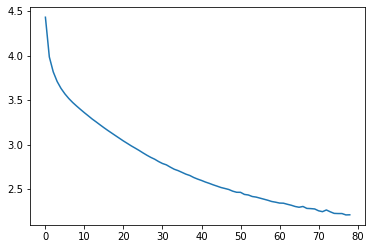

In [4]:
history = [4.4296, 3.9846, 3.8174, 3.7093, 3.6310, 3.5694, 3.5174, 3.4727, 3.4330, 3.3950, 3.3582, 3.3230, 3.2873, 3.2555, 3.2225, 3.1903, 3.1594, 3.1298, 3.1001, 3.0708, 3.0413, 3.0141, 2.9864, 2.9614, 2.9356, 2.9080, 2.8817, 2.8575, 2.8369, 2.8108, 2.7887, 2.7735, 2.7481, 2.7246, 2.7089, 2.6893, 2.6692, 2.6543, 2.6318, 2.6140, 2.5985, 2.5808, 2.5659, 2.5493, 2.5345, 2.5193, 2.5085, 2.4970, 2.4784, 2.4660, 2.4653, 2.4418, 2.4356, 2.4185, 2.4119, 2.4001, 2.3883, 2.3763, 2.3624, 2.3546, 2.3448, 2.3434, 2.3313, 2.3205, 2.3065, 2.2978, 2.3066, 2.2850, 2.2827, 2.2788, 2.2582, 2.2483, 2.2674, 2.2468, 2.2291, 2.2273, 2.2272, 2.2119, 2.2132, ]
plt.plot(np.arange(len(history)), history)

## Translate

* The evaluate function is similar to the training loop, except we don't use *teacher forcing* here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the *end token*.
* And store the *attention weights for every time step*.

Note: The encoder output is calculated only once for one input.

In [24]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    sentence = preprocess_sentence(sentence)

    inputs = [tokenizer.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen=max_length_inp, padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()
        result += tokenizer.index_word[predicted_id] + ' '

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [25]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [26]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

## Restore the latest checkpoint and test

In [27]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [28]:
translate(u'turtle reviewtitle i hate it')

Input: <start> turtle reviewtitle i hate it <end>
Predicted translation: <unk> <unk> . i m going to be a <unk> in sight . <end> 


In [29]:
translate(u'game reviewtitle good game this is')

Input: <start> game reviewtitle good game this is <end>
Predicted translation: game play . <end> 


In [30]:
translate(u'game of blocks reviewtitle awful')

Input: <start> game of blocks reviewtitle awful <end>
Predicted translation: game . i m satisfied . <end> 


In [31]:
translate(u'game of blocks reviewtitle good but bad')

Input: <start> game of blocks reviewtitle good but bad <end>
Predicted translation: fun and i m satisfied . <end> 


# Beam search on results

In [32]:
def beam_search(sentence, guesses_number, width=100):
    sentence = preprocess_sentence(sentence)

    inputs = [tokenizer.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen=max_length_inp, padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = int(tokenizer.word_index['<start>'])

    top_guesses = []
    current_guesses = [[[dec_input], tf.identity(dec_hidden), 0]]
    for t in range(max_length_targ):
        current_guesses_expanded = []
        # Iterate over all current coditions
        for guess in current_guesses:
            dec_input = tf.expand_dims([guess[0][-1]], 0)
            predictions, dec_hidden, _ = decoder(dec_input, guess[1], enc_out)
            predictions = tf.nn.softmax(predictions[0])
            
            top_ids = tf.argsort(predictions, direction='DESCENDING')[:width]
            scores = guess[2] + tf.math.log(tf.clip_by_value(tf.gather(predictions, top_ids), 0.001, 1))
            
            # Add new word ids
            word_ids = [guess[0] + [int(id)] for id in top_ids]

            current_guesses_expanded += list(np.array([word_ids, 
                                                       [dec_hidden] * width, 
                                                       scores.numpy().tolist()]).T)
        
        current_guesses = sorted(current_guesses_expanded, key=lambda x: -x[2])[:width]
        
        # Add guess to top_guesses if encounter <end> token
        done_idxs = [guess_idx for guess_idx in range(len(current_guesses))
                     if tokenizer.index_word[int(current_guesses[guess_idx][0][-1])] == '<end>']
        done_guesses = np.take(current_guesses, done_idxs, axis=0)
        # Normalize score by length
        done_guesses = [[guess[0], guess[2] / (t+1)] for guess in done_guesses]
        top_guesses += done_guesses
        current_guesses = [guess for idx, guess in enumerate(current_guesses)
                           if idx not in done_idxs]
        
        if len(current_guesses) == 0 or len(top_guesses) >= guesses_number:
            break
    
    top_guesses.sort(key=lambda x: -x[1])
    for i, guess in enumerate(top_guesses):
        top_guesses[i][0] = ' '.join(tokenizer.index_word[predicted_id] for predicted_id in guess[0])
    return top_guesses

In [33]:
for string in [u'turtle reviewtitle i hate it',
               u'game reviewtitle good game this is',
               u'game of blocks reviewtitle awful',
               u'fly and jump game reviewtitle i am in love']:
    print(string)
    display(beam_search(string, guesses_number=10, width=100))
    print()

turtle reviewtitle i hate it


[['<start> <unk> fan . <end>', -1.262439250946045],
 ['<start> <unk> <unk> . <end>', -1.4593329429626465],
 ['<start> ever <unk> . <end>', -1.477128267288208],
 ['<start> ever had . <end>', -1.518937110900879],
 ['<start> ever seen . <end>', -1.5623829364776611],
 ['<start> game <unk> . <end>', -1.5928157567977905],
 ['<start> ever opened . <end>', -1.6117451190948486],
 ['<start> <unk> finish . <end>', -1.6639404296875],
 ['<start> game had . <end>', -1.739352822303772],
 ['<start> <unk> died . <end>', -1.743628978729248],
 ['<start> <unk> work . <end>', -1.768803596496582],
 ['<start> ever attached . <end>', -1.7690125703811646],
 ['<start> in places . <end>', -1.793155550956726],
 ['<start> game work . <end>', -1.8053075075149536],
 ['<start> ever used . <end>', -1.822326421737671],
 ['<start> <unk> dog . <end>', -1.8853189945220947],
 ['<start> happens . <end>', -2.097435633341471]]


game reviewtitle good game this is


[['<start> game play . <end>', -1.2143914699554443],
 ['<start> game ever . <end>', -1.4110758304595947],
 ['<start> good game . <end>', -1.5447962284088135],
 ['<start> ever made . <end>', -1.5718624591827393],
 ['<start> fun game . <end>', -1.6512558460235596],
 ['<start> different experience . <end>', -1.7071799039840698],
 ['<start> battlefield type . <end>', -1.7381821870803833],
 ['<start> graphics fan . <end>', -1.7882578372955322],
 ['<start> game plays . <end>', -1.837547779083252],
 ['<start> game has . <end>', -1.8395144939422607],
 ['<start> battlefield good . <end>', -1.8576164245605469],
 ['<start> entertaining game . <end>', -1.8805241584777832],
 ['<start> plot twist . <end>', -1.8896340131759644],
 ['<start> game . . <end>', -1.9018771648406982],
 ['<start> game . <end>', -2.0283168156941733],
 ['<start> battlefield . <end>', -2.0291603406270347]]


game of blocks reviewtitle awful


[['<start> wow . <end>', -1.6562786102294922],
 ['<start> great game <end>', -1.6784863471984863],
 ['<start> great graphics <end>', -1.6950899759928386],
 ['<start> game . <end>', -1.8375898996988933],
 ['<start> fun . <end>', -2.020284334818522],
 ['<start> user interface <end>', -2.0372241338094077],
 ['<start> great gameplay <end>', -2.148651123046875],
 ['<start> c <unk> <end>', -2.241889317830404],
 ['<start> video game <end>', -2.243744214375814],
 ['<start> endless <unk> <end>', -2.2802206675211587],
 ['<start> c <end>', -2.8234329223632812],
 ['<start> sure <end>', -2.956500291824341],
 ['<start> . <end>', -2.9684572219848633],
 ['<start> game <end>', -3.0092759132385254],
 ['<start> dlc <end>', -3.0684807300567627],
 ['<start> <unk> <end>', -3.1416046619415283],
 ['<start> gameplay <end>', -3.1476223468780518],
 ['<start> sense <end>', -3.2024102210998535],
 ['<start> <end>', -6.400173187255859]]


fly and jump game reviewtitle i am in love


[['<start> fun . <end>', -1.2186179955800374],
 ['<start> ok . <end>', -1.3222084045410156],
 ['<start> <unk> . <end>', -1.6134808858235676],
 ['<start> best . <end>', -1.9635475476582844],
 ['<start> great . <end>', -2.1374050776163735],
 ['<start> played . <end>', -2.1409972508748374],
 ['<start> required . <end>', -2.185060660044352],
 ['<start> played it <end>', -2.195972124735514],
 ['<start> wow . <end>', -2.241674264272054],
 ['<start> played <end>', -2.901339054107666],
 ['<start> <unk> <end>', -2.974656105041504]]

#### It looks at condition!

In [34]:
x[0]

array([ 21, 108,   6, 109, 110,  46, 111, 112,  47,  14,  48,  12,   7,
         3,  49,   3,  50,  51,  17,  52,  53,  54,   4,  10,  14,  55,
        56,  57,  15,  58,  59,  19,   2,  60,   3,  10,  20,   8,  61,
        62,   9,  32,   2,  63,  33,  64,  65,  66,   5,   4,   2,  67,
         6,  34,  68,  69,  70,  71,  72,  22,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

In [42]:
string = 'castle battle reviewtitle love it reviewcontent this game is beautiful. Nice one experience!'
display(translate(string))#, guesses_number=10, width=100))


Input: <start> castle battle reviewtitle love it reviewcontent this game is beautiful . nice one experience ! <end>
Predicted translation: this game is repetitive . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 


None